In [1]:
import codecs
import yaml

import rqalpha as rqa
import rqalpha_plus
import rqdatac as rqd
import pandas as pd
import numpy as np
import pickle
import os
import utils

In [2]:
def _init_rqdata(conf_path):
    with codecs.open(conf_path, 'r', encoding='utf8') as stream:
        conf = yaml.load(stream)
        if 'proxy' in conf:
            proxy_info = (conf['proxy'].get('type'),
                conf['proxy'].get('host'),
                conf['proxy'].get('port'),
                conf['proxy'].get('user'),
                conf['proxy'].get('password'))
        else:
            proxy_info = None
        rqd.init(conf['rqdata_username'], conf['rqdata_password'],
            (conf['rqdata_host'], conf['rqdata_port']), proxy_info=proxy_info)


In [3]:
def get_target_stocks(context, factor, ascending, percent_selected, min_selected, grouper):
    """获得当天需要买入的股票"""
    # 前一个交易日
    selection_date = rqd.get_previous_trading_date(context.now)
    # 前一个交易日的指数成分股
    universe = rqd.index_components(context.index_stockpool, selection_date)
    # 剔除停牌
    universe = utils.drop_suspended(universe, selection_date)
    # 剔除ST
    universe = utils.drop_st(universe, selection_date)
    # 剔除上市小于60天
    universe = utils.drop_recently_listed(universe, selection_date, 60)
    # 获得因子分数
    scores = utils.get_factor(universe, factor, selection_date, selection_date)
    # 返回需要买入的股票
    return utils.select_top_N_percent(
        universe, selection_date, scores, percent_selected, ascending, min_selected,
        grouper=grouper
    )


def get_target_portfolio(context):
    # =====返回每只股票的权重Series=====
    date = context.now
    universe = context.target_stocks
    benchmark = context.benchmark
    # 今天指数成分股
    components = rqd.index_components(benchmark,date)
    # 股票所属行业series
    industry = utils.get_industry(components,date)
    # 指数行业权重
    industry_weight = rqd.index_weights(benchmark,date).groupby(industry).sum()
    # 目标股票市值
    market_cap = rqd.get_factor(universe,'market_cap',date,date)
    # 股票行业分组组内市值加权
    universe_industry = utils.get_industry(universe,date)
    weight_in_industry = market_cap.groupby(universe_industry).apply(lambda x:x/x.sum())
    # 股票行业目标权重
    target_ids_weight = universe_industry.map(industry_weight)
    # 对于某些股票所属行业在中证500里面没有权重的设为0
    target_ids_weight.fillna(0, inplace=True)
    # 股票最终权重
    return weight_in_industry*target_ids_weight
    
def init(context):
    _init_rqdata('rqpro.yml')
    utils._RICEQUANT_FACTORS = rqd.get_all_factor_names()
    
def handle_bar(context, bar_dict):
    # 如果是False(不是月初),直接返回
    if not _should_rebalance(context):
        return
    print(context.now)
    print("现有持仓数:", len(context.portfolio.positions))
    context.target_stocks = get_target_stocks(context, **context.stock_selection_args)
    context.target_portfolio = get_target_portfolio(context)
    rebalance(context, bar_dict)


def _should_rebalance(context):
    """判断今天是否调仓"""
    # 获得上一个交易日
    prev_trading_day = rqd.get_previous_trading_date(context.now)
    # 判断是否是月初, 是月初返回True
    is_month_start = (prev_trading_day.month != context.now.month)
    return is_month_start


def rebalance(context, bar_dict):
    
    positions = context.portfolio.positions
    for order_book_id in positions:
        if order_book_id not in context.target_portfolio:
            rqa.api.order_to(order_book_id, 0)
    
    # 对每个股票计算目标价值和当前价值的差值
    # 差值为正的是买单, 反之为卖单
    capital = context.portfolio.total_value * (1 - context.cash_cushion)
    to_sell, to_buy = {}, {}
    _money_for_one_lot = lambda order_book_id: bar_dict[order_book_id].close * 100
    for order_book_id, weight in context.target_portfolio.items():
        # 股票目标价值
        target_value = capital * weight
        # 目标和现有之差
        gap = target_value - positions[order_book_id].market_value
        # 买卖至少大于1手股票价值
        if abs(gap)<_money_for_one_lot(order_book_id):
            continue
        elif gap > 0:
            to_buy[order_book_id] = gap
        else:
            to_sell[order_book_id] = gap

    # to avoid liquidity issue, sell first, buy second
    for order_book_id, value in to_sell.items():
        rqa.api.order_value(order_book_id, value)
    for order_book_id, value in to_buy.items():
        rqa.api.order_value(order_book_id, value)

# 回测

## 参数

In [9]:
MILLION = 1_000_000
BILLION = 1000 * MILLION
benchmark = '000905.XSHG'
stockpool = '000985.XSHG'
fac = 'private.Hacken_Dividend_Org'
asc = False
config = {
    "base": {
        "matching_type": "current_bar",
        "start_date": '2014-03-01',
        "end_date": '2020-08-17',
        "frequency": '1d',
        "accounts": {"stock": 0.1 * BILLION},
        "data_bundle_path":r'C:\Users\Administrator\.rqalpha-plus\bundle'
    },
    "mod": {
        "sys_analyser": {
            "enabled": True,
            "plot": True,
            "benchmark": benchmark,
        },
        'sys_simulation': {
            # 撮合时无视涨跌停
            'price_limit': False,
        },
        'sys_risk': {
            'enabled': True,
            # 发单时无视停牌
            'validate_is_trading': False,
            # 发单时无视涨跌停
            'validate_price': False
        },
    },
    "extra": {
        "log_level": 'error',
        "context_vars": {
            'cash_cushion': 0.005,
            'index_stockpool': stockpool,
            'benchmark': benchmark,
            'stock_selection_args': {
                'factor': fac,
                'ascending': asc,
                'percent_selected': 0.1,
                'min_selected': 8,
                'grouper': True
            },
        },
    },
}


F:\anaconda\envs\ricequant\lib\site-packages\rqdatac\client.py:190: UserWarning: rqdatac is already inited. Settings will be changed.
  warnings.warn("rqdatac is already inited. Settings will be changed.", stacklevel=0)
F:\anaconda\envs\ricequant\lib\site-packages\rqalpha\user_module.py:3: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  #
[2014-03-03 15:00:00.000000] INFO: user_log: 2014-03-03 15:00:00
[2014-03-03 15:00:00.000000] INFO: user_log: 现有持仓数: 0
[2014-04-01 15:00:00.000000] INFO: user_log: 2014-04-01 15:00:00
[2014-04-01 15:00:00.000000] INFO: user_log: 现有持仓数: 246
[2014-05-05 15:00:00.000000] INFO: user_log: 2014-05-05 15:00:00
[2014-05-05 15:00:00.000000] INFO: user_log: 现有持仓数: 249
[2014-06-03 15:00:00.000000] INFO: user_log: 2014-06-03 15:00:00
[2014-06-03 15:00:00.000000] INFO: user_log: 现有持仓数: 251
[2014-07-01 15:00:00.000000] INFO: user_log: 2014-07-01 15:00

[2019-07-01 15:00:00.000000] INFO: user_log: 2019-07-01 15:00:00
[2019-07-01 15:00:00.000000] INFO: user_log: 现有持仓数: 348
[2019-08-01 15:00:00.000000] INFO: user_log: 2019-08-01 15:00:00
[2019-08-01 15:00:00.000000] INFO: user_log: 现有持仓数: 349
[2019-09-02 15:00:00.000000] INFO: user_log: 2019-09-02 15:00:00
[2019-09-02 15:00:00.000000] INFO: user_log: 现有持仓数: 350
[2019-10-08 15:00:00.000000] INFO: user_log: 2019-10-08 15:00:00
[2019-10-08 15:00:00.000000] INFO: user_log: 现有持仓数: 267
[2019-11-01 15:00:00.000000] INFO: user_log: 2019-11-01 15:00:00
[2019-11-01 15:00:00.000000] INFO: user_log: 现有持仓数: 269
[2019-12-02 15:00:00.000000] INFO: user_log: 2019-12-02 15:00:00
[2019-12-02 15:00:00.000000] INFO: user_log: 现有持仓数: 266
[2020-01-02 15:00:00.000000] INFO: user_log: 2020-01-02 15:00:00
[2020-01-02 15:00:00.000000] INFO: user_log: 现有持仓数: 266
[2020-02-03 15:00:00.000000] INFO: user_log: 2020-02-03 15:00:00
[2020-02-03 15:00:00.000000] INFO: user_log: 现有持仓数: 269
[2020-03-02 15:00:00.000000] INF

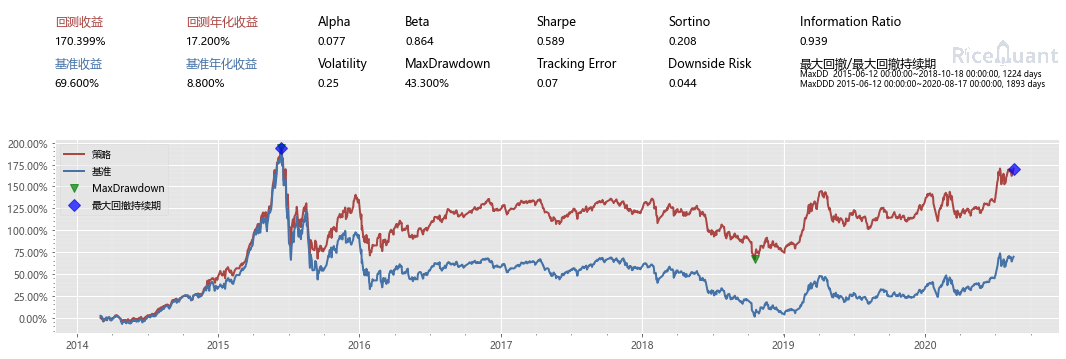

In [10]:
res = rqalpha_plus.run_func(init=init,handle_bar=handle_bar, config=config)

---

In [11]:
if not os.path.exists(f'{fac}'):
    os.makedirs(f'{fac}')
with open(f'{fac}/{fac}.pkl', 'wb') as pf:
    pickle.dump((config, res), pf)
res['sys_analyser']['trades'].to_csv(f'{fac}/trades.csv')